In [1]:
from src import data, models, layers, utils, losses, plotter
from importlib import reload 
import tensorflow as tf 
import tensorflow_probability.python.distributions as tfd
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import networkx as nx
import plotly.graph_objects as go 
from sklearn.manifold import TSNE

2024-04-15 13:17:13.648070: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-15 13:17:13.652734: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-15 13:17:14.500568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-15 13:17:16.771553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-15 13:17:36.537032: W tensorflow/compiler/tf2

In [65]:
reload(utils)
reload(losses)
reload(layers)
reload(models)
reload(data)
#path = "A:\\Users\\Claudio\\Documents\\Data\\Networks\\Dynamic\\BACI_HS92_V202301"
path = "/mnt/a/Users/Claudio/Documents/Data/Networks/Dynamic/BACI_HS92_V202301"
save_path = "./data/1995_2010"

In [3]:
baci_loader = data.BaciDataLoader()

In [ ]:
from_year = 2007
to_year = 2010
by = 2
for i in range(from_year, to_year, by):
    baci_loader2 = data.BaciDataLoader()
    baci_loader2.from_csv_path(path, i, i + by-1)
    baci_loader2.remove_countries()
    baci_loader2.reduce_product_detail(2)
    baci_loader2.select_products(['84'])
    baci_loader2.fill_missing_with_avg()
    baci_loader.join(baci_loader2)
    del baci_loader2

baci_loader.save(save_path)

In [4]:
baci_loader = data.BaciDataLoader()
baci_loader.load(save_path)
years = len(baci_loader.years)
spt = baci_loader.to_tf_sparse()

Loading Data from ./data/1995_2010
Building Sparse Index List


100%|██████████| 206143/206143 [00:08<00:00, 22932.82it/s]
2024-04-15 13:19:09.922728: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 13:19:10.591939: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 13:19:10.592181: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-15 13:19:10.602858: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-1

In [13]:
sliced = tf.sparse.slice(spt, (0, 0, 0, 0, 0), (years, 171, 171, 1, 1))
np.save("./sparse_indices.npy", sliced.indices.numpy()[:, :3])

In [6]:
dense = tf.sparse.to_dense(tf.sparse.slice(spt, (0,0,0,0,0), (years, 171, 171, 1, 1)))[...,0, 0]
adj = tf.cast(tf.expand_dims(dense, 0), tf.float32)
adj_binary = tf.cast(adj>0, tf.float32)
adj_in = tf.where(adj>1., tf.math.log(adj), 0.)
x = tf.cast(tf.constant([np.eye(171)]*years)[None,:], tf.float32)
adj_symm = []
for t in range(years):
    a = utils.symmetrize_dense(adj_binary[0, t].numpy())
    adj_symm.append(a)
adj_symm = np.asarray(adj_symm)
adj_symm = tf.cast(adj_symm[None], tf.float32)

In [295]:
model = models.VRNNGATWeighted(
    nodes=171,
    dropout=0,
    recurrent_dropout=0,
    attn_heads=1,
    channels=30,
    single_gat=False,
    gat_type="gat",
    add_bias=False,
    diagonal=False,
    activation="elu"
)
model.compile("rmsprop")
_ = model((x[:, :-1], adj[:, :-1, :, :]))

In [296]:
schedule = utils.Scheduler("kl_weight", 100)
history1 = model.fit((x[:, :-1], adj[:,:-1, :, :]), adj[:,1:, :, :], epochs=200, callbacks=[schedule])

Epoch 1/200
1/1 [==============================] - 38s 38s/step - nll: 21.2916 - kl: 0.1547
Epoch 2/200
1/1 [==============================] - 1s 1s/step - nll: 19.7776 - kl: 0.3232
Epoch 3/200
1/1 [==============================] - 1s 1s/step - nll: 18.2514 - kl: 0.8893
Epoch 4/200
1/1 [==============================] - 1s 1s/step - nll: 17.4295 - kl: 2.1164
Epoch 5/200
1/1 [==============================] - 1s 1s/step - nll: 16.6484 - kl: 5.4631
Epoch 6/200
1/1 [==============================] - 1s 1s/step - nll: 15.7921 - kl: 13.1255
Epoch 7/200
1/1 [==============================] - 1s 1s/step - nll: 14.6834 - kl: 32.9014
Epoch 8/200
1/1 [==============================] - 1s 1s/step - nll: 12.4600 - kl: 92.4757
Epoch 9/200
1/1 [==============================] - 1s 1s/step - nll: 5.9475 - kl: 258.7201
Epoch 10/200
1/1 [==============================] - 1s 1s/step - nll: 3.3394 - kl: 387.0298
Epoch 11/200
1/1 [==============================] - 1s 1s/step - nll: 3.1744 - kl: 346.1567


In [297]:
samples = tf.squeeze(model.sample((x, adj_binary)))
*_, o, _ = model((x, adj_binary))

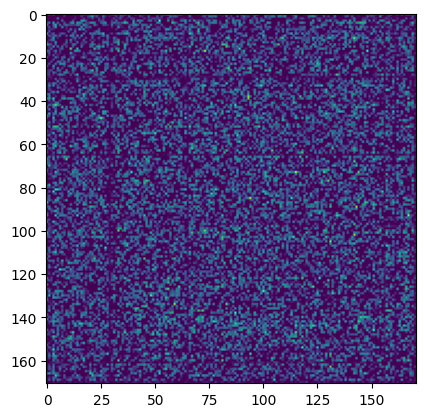

In [298]:
plt.imshow(tf.math.log(samples[0] +1))

In [305]:
modelb = models.VRNNGATBinary(
    nodes=171,
    dropout=0,
    recurrent_dropout=0,
    attn_heads=1,
    channels=50,
    single_gat=True,
    gat_type="gat",
    add_bias=True,
    diagonal=False,
    adj_pos=False, 
    activation="sigmoid"
)
modelb.kl_weight = 1e-4
modelb.compile("rmsprop")
_ = modelb((x[:, :-1], adj_binary[:, :-1, :, :]))

In [300]:
schedule = utils.Scheduler("kl_weight", 100)
history1b = modelb.fit((x[:, :5], adj_binary[:,:5, :, :]), adj_binary[:,1:6, :, :], epochs=250)#, callbacks=[schedule])

Epoch 1/250
1/1 [==============================] - 27s 27s/step - nll: 0.7468 - kl: 20.2731
Epoch 2/250
1/1 [==============================] - 1s 528ms/step - nll: 0.7284 - kl: 18.1907
Epoch 3/250
1/1 [==============================] - 0s 455ms/step - nll: 0.7230 - kl: 16.8561
Epoch 4/250
1/1 [==============================] - 0s 427ms/step - nll: 0.7065 - kl: 15.9218
Epoch 5/250
1/1 [==============================] - 0s 464ms/step - nll: 0.7015 - kl: 15.1580
Epoch 6/250
1/1 [==============================] - 0s 492ms/step - nll: 0.6946 - kl: 14.6638
Epoch 7/250
1/1 [==============================] - 1s 579ms/step - nll: 0.6937 - kl: 14.1089
Epoch 8/250
1/1 [==============================] - 1s 528ms/step - nll: 0.6966 - kl: 13.5209
Epoch 9/250
1/1 [==============================] - 0s 486ms/step - nll: 0.6829 - kl: 13.2732
Epoch 10/250
1/1 [==============================] - 0s 486ms/step - nll: 0.6732 - kl: 13.0132
Epoch 11/250
1/1 [==============================] - 1s 524ms/step - nl

In [301]:
samplesb = tf.squeeze(modelb.sample_adjacency((x, adj_binary)))
*_, o, _ = modelb((x, adj_binary))

In [302]:
bern = tfd.Independent(tfd.Bernoulli(logits=o[..., 0]), reinterpreted_batch_ndims=2)
samplesb1 = bern.sample(1)[0,0]

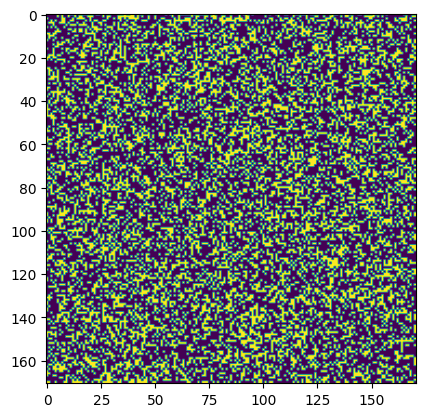

In [303]:
plt.imshow(samplesb[-1])

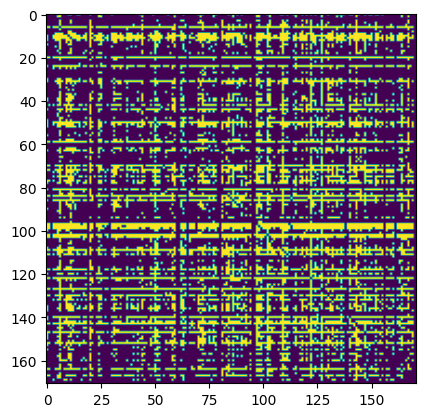

In [65]:
plt.imshow(adj_binary[0,0])

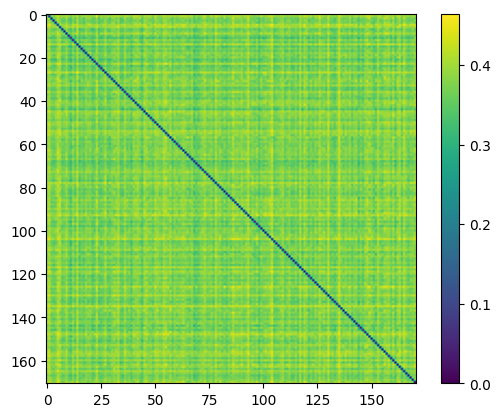

In [304]:
plt.imshow(tf.nn.sigmoid(o[0, -1]))
plt.colorbar()

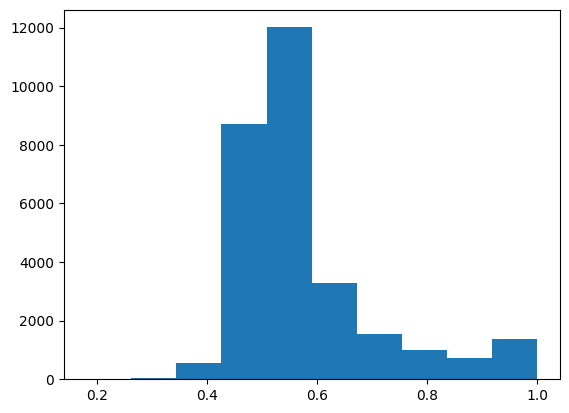

In [47]:
_ = plt.hist(tf.nn.sigmoid(o[0, 0]).numpy().flatten())

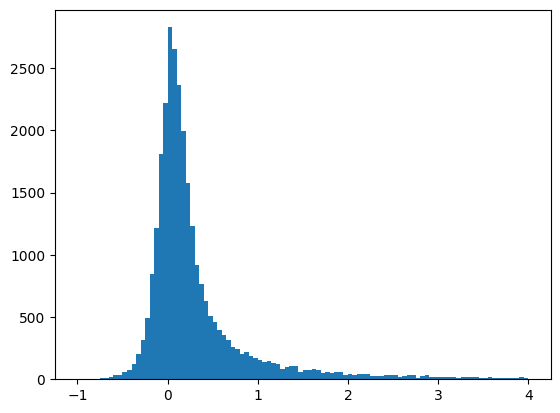

In [46]:
_ = plt.hist(o[0, 0].numpy().flatten(), range=(-1, 4), bins=100)

(array([13857.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 15384.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

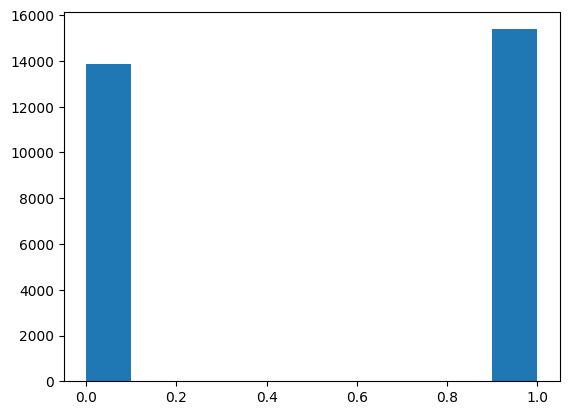

In [273]:
plt.hist(adj_binary[0,-1].numpy().flatten())

In [158]:
i = tf.keras.Input(shape=(171, 171))
i2 = tf.keras.Input(shape=(171, 171))
gat = layers.GATConv(attn_heads=1, channels=10, activation="sigmoid")
#gat = layers.SelfAttention(attn_heads=1, channels=10, activation="sigmoid")
bil = layers.BatchMultiBilinearDecoderDense("linear", depth=1, mask_diag=True)
ox = tf.keras.layers.Dense(15)
o = ox(i)
o = gat((o, i2))
o1 = bil(o)
bilm = tf.keras.models.Model([i, i2], [o, o1])

/mnt/a/Users/Claudio/Documents/PROJECTS/VariationalRecurrentGNN/linux_venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [ ]:
ix = np.eye(171)[None]
optim = tf.keras.optimizers.RMSprop()
for i in range(500):
    with tf.GradientTape() as tape:
        _, ob = bilm((ix, adj_binary[:, 0]))
        loss = tf.reduce_mean(tf.keras.losses.binary_crossentropy(adj_binary[:, 0][..., None], ob, from_logits=True))
        print(loss)
    grad = tape.gradient(loss, bilm.trainable_variables)
    optim.apply_gradients(zip(grad, bilm.trainable_variables))
ox, ob = bilm(([ix],adj_binary[:, 0]))

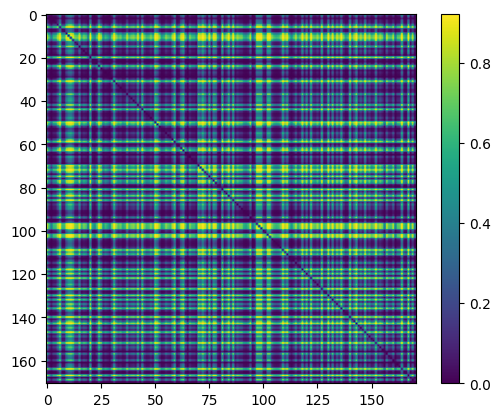

In [161]:
plt.imshow(tf.nn.sigmoid(ob[0, :, :, 0]))
plt.colorbar()

In [162]:
bbern = tfd.Independent(tfd.Bernoulli(ob[..., 0]), reinterpreted_batch_ndims=2)

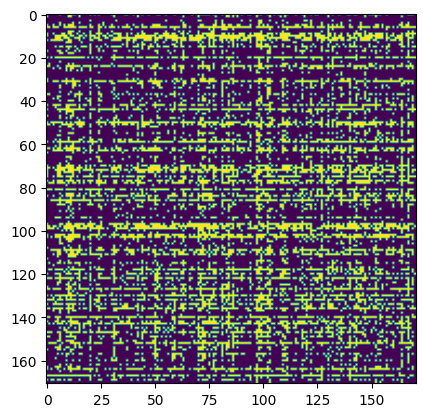

In [163]:
bsamples = bbern.sample(1)
plt.imshow(bsamples[0,0])

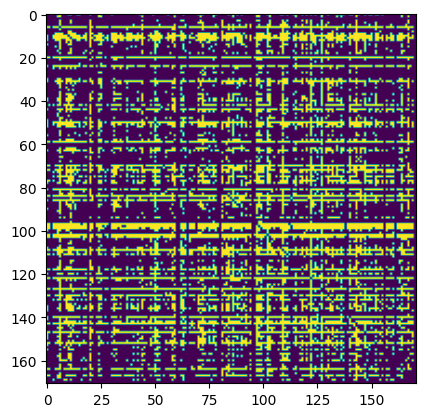

In [89]:
plt.imshow(adj_binary[0,0])

In [93]:
tsne = TSNE(n_components=2, perplexity=4).fit_transform(ox[0].numpy())

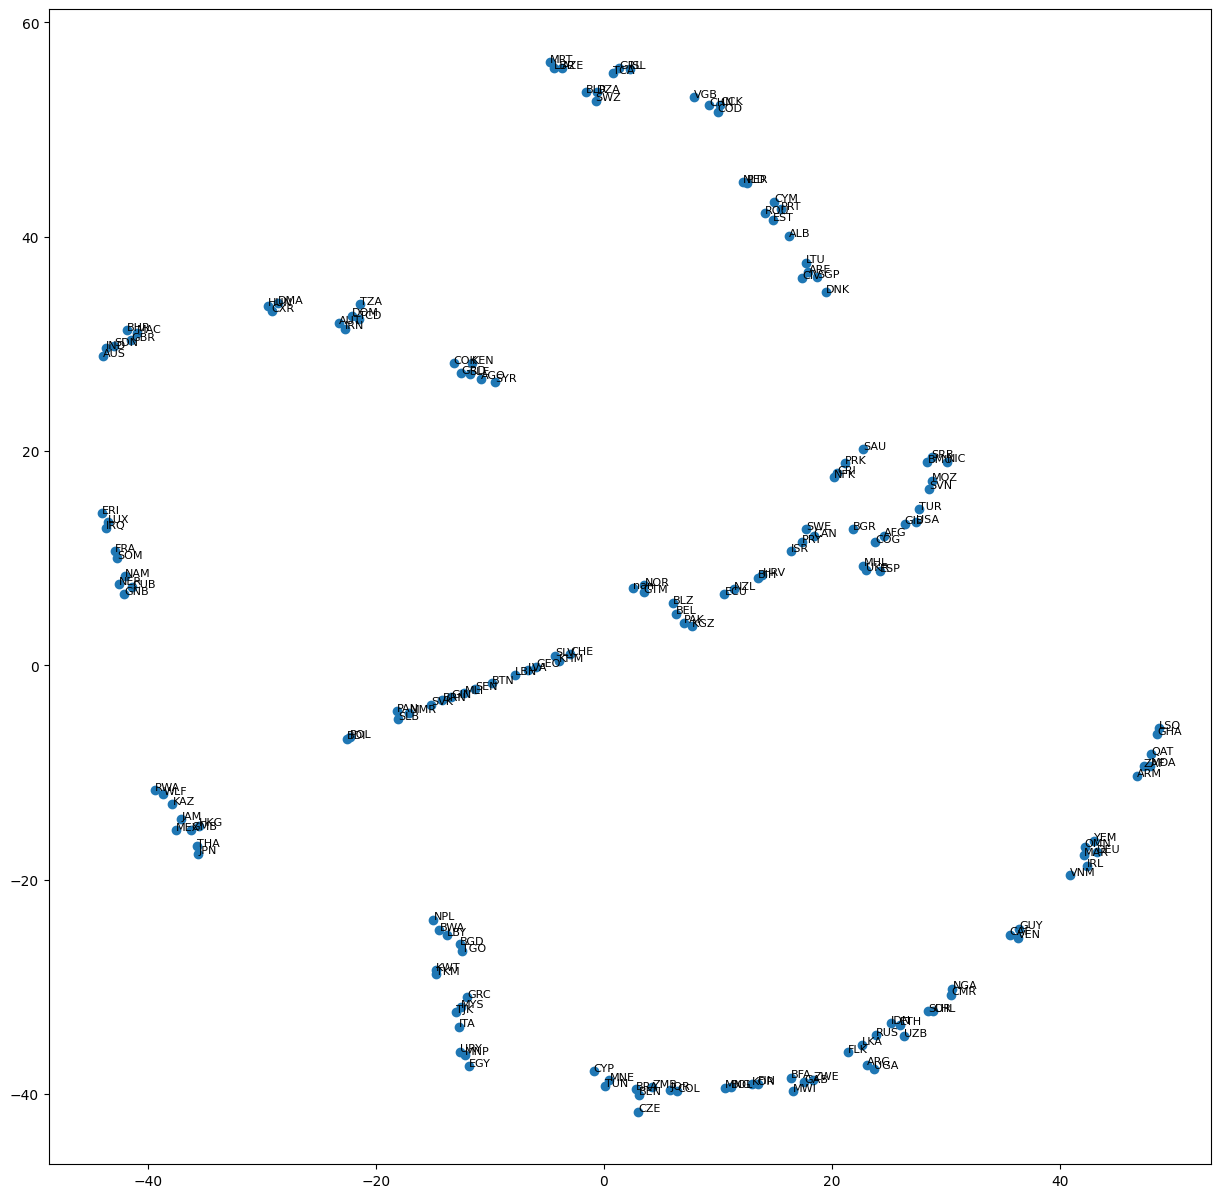

In [94]:
plt.figure(figsize=(15, 15))
plt.scatter(tsne[:, 0], tsne[:, 1])
for x, y, t in zip(tsne[:, 0], tsne[:, 1], baci_loader.countries("iso3")):
    plt.text(x, y, t, fontdict={"fontsize":8})

(array([16169.,  1832.,  1128.,   804.,   689.,   786.,   598.,   685.,
          926.,  5624.]),
 array([4.77434793e-11, 1.00000001e-01, 2.00000003e-01, 3.00000012e-01,
        4.00000006e-01, 5.00000000e-01, 6.00000024e-01, 6.99999988e-01,
        8.00000012e-01, 8.99999976e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

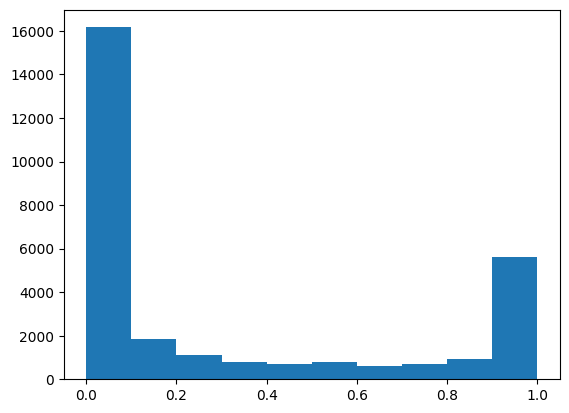

In [114]:
plt.hist(tf.nn.sigmoid(ob[0, :, :, 0] ).numpy().flatten())

In [97]:
def lognormal_loss(labels, logits):
    labels = tf.expand_dims(labels, -1)
    return losses.zero_inflated_nlikelihood(
                                        labels,
                                        logits, 
                                        mean_axis=None, 
                                        distribution="lognormal")
i1, i2 = tf.keras.Input(shape=(None, 171, 171)),  tf.keras.Input(shape=(None, 171, 171))
rnn_gat = models.RNNGAT(
                nodes=171,
                dropout=0,
                recurrent_dropout=0,
                attn_heads=1,
                channels=30,
                out_channels=30, 
                activation="gelu",
                gnn_type="gat",
                add_bias=True,
                h_gnn=True,
                )
decoder = layers.BatchMultiBilinearDecoderDense(depth=3, diagonal=False, mask_diag=True, activation="linear")
xo, xp = rnn_gat((i1, i2))
xa = decoder(xp)
model2 = tf.keras.models.Model((i1, i2), (xa))
model2.compile(optimizer="rmsprop", loss=lognormal_loss, metrics=lognormal_loss)
logits = model2((x, adj), training=True)

/mnt/a/Users/Claudio/Documents/PROJECTS/VariationalRecurrentGNN/linux_venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [98]:
history2 = model2.fit(x=(x[:, :-1], adj[:,:-1]), y=adj[:,1:], epochs=1500, verbose=1)
samples2 = tf.squeeze(utils.zero_inflated_lognormal(logits).sample(20))
samples2_mean = tf.squeeze(tf.reduce_mean(utils.zero_inflated_lognormal(logits).sample(20), 0))

Epoch 1/1500
1/1 [==============================] - 17s 17s/step - loss: 0.0000e+00 - lognormal_loss: 13.3948
Epoch 2/1500
1/1 [==============================] - 0s 497ms/step - loss: 0.0000e+00 - lognormal_loss: 13.3845
Epoch 3/1500
1/1 [==============================] - 1s 533ms/step - loss: 0.0000e+00 - lognormal_loss: 13.3113
Epoch 4/1500
1/1 [==============================] - 0s 461ms/step - loss: 0.0000e+00 - lognormal_loss: 13.0842
Epoch 5/1500
1/1 [==============================] - 0s 494ms/step - loss: 0.0000e+00 - lognormal_loss: 12.5596
Epoch 6/1500
1/1 [==============================] - 1s 503ms/step - loss: 0.0000e+00 - lognormal_loss: 11.6002
Epoch 7/1500
1/1 [==============================] - 0s 453ms/step - loss: 0.0000e+00 - lognormal_loss: 10.1715
Epoch 8/1500
1/1 [==============================] - 0s 481ms/step - loss: 0.0000e+00 - lognormal_loss: 8.4348
Epoch 9/1500
1/1 [==============================] - 1s 508ms/step - loss: 0.0000e+00 - lognormal_loss: 6.7339
Epoc

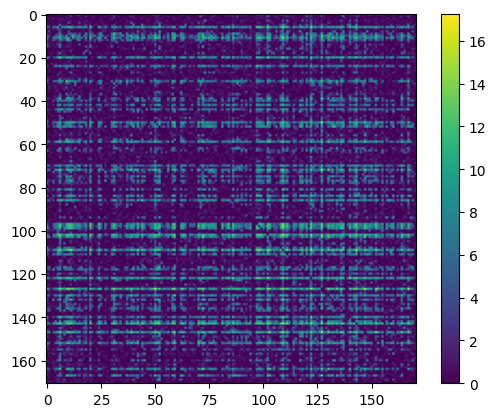

In [100]:
T = 2
adj_in = adj[0, :, :,:]
log_samples2 = np.where(samples2[0]>0, np.log(samples2[0]+1), 0)
log_inputs2 = np.where(adj_in>0, np.log(adj_in+1), 0)
abs_diff2 = np.abs(log_samples2 - log_inputs2)
plt.imshow(abs_diff2[T])
plt.colorbar()

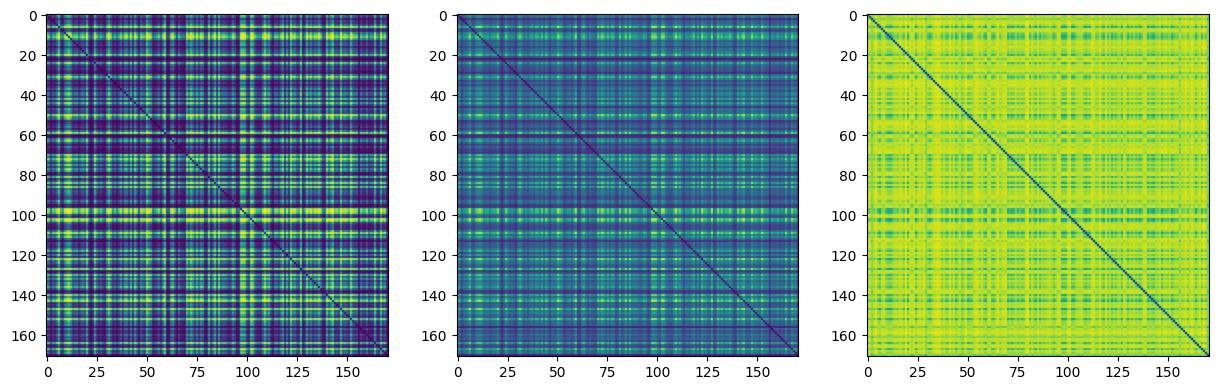

In [106]:
N = 171
logits = model2((x, adj), training=False)
fig, ax = plt.subplots(1,3, figsize=(15, 15))
ax[0].imshow(tf.nn.sigmoid(logits[0, 0,:N, :N, 0]))
ax[1].imshow(logits[0, 0,:N, :N, 1] * (1-tf.eye(N)))
ax[2].imshow(logits[0, 0,:N, :N, 2]* (1-tf.eye(N)))


In [72]:
def bce(labels, logits):
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(labels[..., None], logits[..., None], from_logits=True))

i1, i2 = tf.keras.Input(shape=(None, 171, 171)),  tf.keras.Input(shape=(None, 171, 171))
rnn_gat = models.RNNGAT(
                nodes=171,
                dropout=0,
                recurrent_dropout=0,
                attn_heads=1,
                channels=30,
                out_channels=30, 
                activation="gelu",
                gnn_type="gat",
                add_bias=True,
                h_gnn=True,
                )
decoder = layers.BatchMultiBilinearDecoderDense(depth=1, diagonal=False, mask_diag=True, activation="linear")
xo, xp = rnn_gat((i1, i2))
xa = decoder(xp)
model2 = tf.keras.models.Model((i1, i2), (xa))
model2.compile(optimizer="rmsprop", loss=bce, metrics=bce)
logits = model2((x, adj_binary), training=True)

/mnt/a/Users/Claudio/Documents/PROJECTS/VariationalRecurrentGNN/linux_venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [87]:
history2 = model2.fit(x=(x[:, :-1], adj_binary[:,:-1]), y=adj_binary[:,1:], epochs=500, verbose=1)

Epoch 1/500
1/1 [==============================] - 0s 469ms/step - loss: 0.0000e+00 - bce: 0.3601
Epoch 2/500
1/1 [==============================] - 1s 534ms/step - loss: 0.0000e+00 - bce: 0.3599
Epoch 3/500
1/1 [==============================] - 0s 479ms/step - loss: 0.0000e+00 - bce: 0.3601
Epoch 4/500
1/1 [==============================] - 0s 467ms/step - loss: 0.0000e+00 - bce: 0.3598
Epoch 5/500
1/1 [==============================] - 0s 451ms/step - loss: 0.0000e+00 - bce: 0.3600
Epoch 6/500
1/1 [==============================] - 0s 464ms/step - loss: 0.0000e+00 - bce: 0.3598
Epoch 7/500
1/1 [==============================] - 0s 480ms/step - loss: 0.0000e+00 - bce: 0.3599
Epoch 8/500
1/1 [==============================] - 0s 474ms/step - loss: 0.0000e+00 - bce: 0.3597
Epoch 9/500
1/1 [==============================] - 1s 562ms/step - loss: 0.0000e+00 - bce: 0.3599
Epoch 10/500
1/1 [==============================] - 0s 483ms/step - loss: 0.0000e+00 - bce: 0.3597
Epoch 11/500
1/1 [=

In [91]:
logits = tf.squeeze(model2((x, adj_binary), training=True))
bern = tfd.Independent(tfd.Bernoulli(logits=logits), reinterpreted_batch_ndims=2)
samplesb = bern.sample(1)[0]

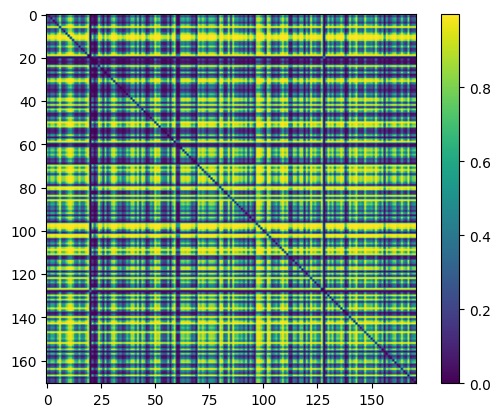

In [94]:
#plt.imshow(logits[-1] * (1-tf.eye(171)))
plt.imshow(tf.nn.sigmoid(logits[-1]))
plt.colorbar()

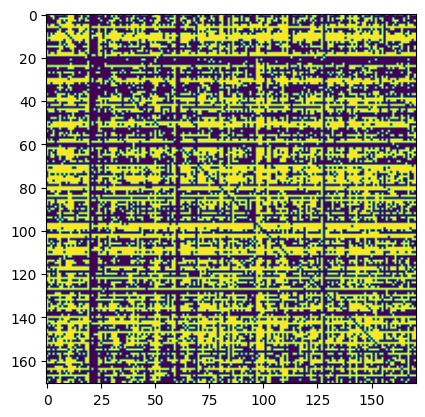

In [95]:
plt.imshow(samplesb[-1])

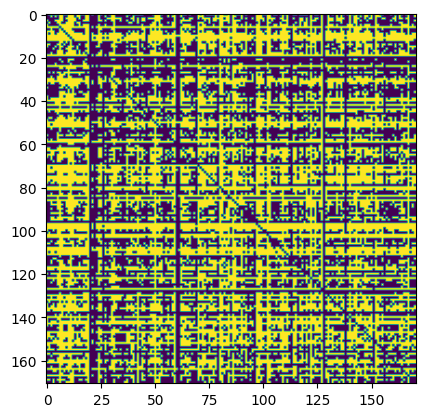

In [96]:
plt.imshow(adj_binary[0, -1])

In [34]:
reload(losses)
activation = "elu"
i = tf.keras.Input(shape=(171, 171))
i2 = tf.keras.Input(shape=(171, 171))
gat = layers.GATConv(attn_heads=1, channels=30, activation=activation)
#gat = layers.SelfAttention(attn_heads=1, channels=10, activation="sigmoid")
bil = layers.BatchMultiBilinearDecoderDense("linear", depth=3, mask_diag=True)
ox = tf.keras.layers.Dense(30, activation=activation)
o = ox(i)
o = gat((o, i2))
o1 = bil(o)
bilw = tf.keras.models.Model([i, i2], [o, o1])
ix = np.eye(171)[None]
optim = tf.keras.optimizers.RMSprop()
for i in range(500):
    with tf.GradientTape() as tape:
        _, ow = bilw((ix, adj[:, 0]))
        loss = tf.reduce_mean(losses.zero_inflated_nlikelihood(adj[:, 0][..., None], ow, mean_axis=None))
        print(f"{i} - {loss.numpy()}")
    grad = tape.gradient(loss, bilw.trainable_variables)
    optim.apply_gradients(zip(grad, bilw.trainable_variables))
ox, ow = bilw(([ix],adj[:, 0]))

/mnt/a/Users/Claudio/Documents/PROJECTS/VariationalRecurrentGNN/linux_venv/lib/python3.11/site-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


tf.Tensor(9.504986, shape=(), dtype=float32)
tf.Tensor(9.50372, shape=(), dtype=float32)
tf.Tensor(9.500283, shape=(), dtype=float32)
tf.Tensor(9.492229, shape=(), dtype=float32)
tf.Tensor(9.475596, shape=(), dtype=float32)
tf.Tensor(9.444599, shape=(), dtype=float32)
tf.Tensor(9.391156, shape=(), dtype=float32)
tf.Tensor(9.305301, shape=(), dtype=float32)
tf.Tensor(9.176232, shape=(), dtype=float32)
tf.Tensor(8.993657, shape=(), dtype=float32)
tf.Tensor(8.749941, shape=(), dtype=float32)
tf.Tensor(8.442177, shape=(), dtype=float32)
tf.Tensor(8.073016, shape=(), dtype=float32)
tf.Tensor(7.650829, shape=(), dtype=float32)
tf.Tensor(7.1889424, shape=(), dtype=float32)
tf.Tensor(6.704048, shape=(), dtype=float32)
tf.Tensor(6.213903, shape=(), dtype=float32)
tf.Tensor(5.735041, shape=(), dtype=float32)
tf.Tensor(5.2809668, shape=(), dtype=float32)
tf.Tensor(4.861195, shape=(), dtype=float32)
tf.Tensor(4.48114, shape=(), dtype=float32)
tf.Tensor(4.1426673, shape=(), dtype=float32)
tf.Tensor

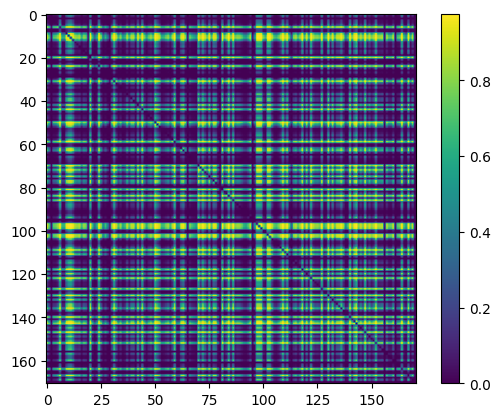

In [35]:
ow_p = tf.nn.sigmoid(ow[0, :, :, 0]) * (1 - tf.eye(171))
ow_m = ow[0, :, :, 1] * (1 - tf.eye(171))
ow_v = ow[0, :, :, 2] * (1 - tf.eye(171))
plt.imshow(ow_p)
plt.colorbar()

In [207]:
logn = utils.zero_inflated_lognormal(ow[0])
logn_samples = logn.sample(10)

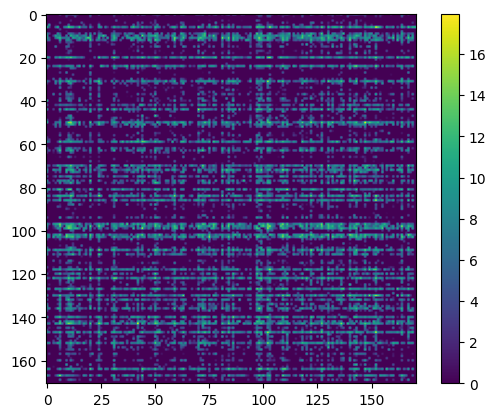

In [232]:
#plt.imshow(tf.math.log(tf.reduce_mean(logn_samples, 0)+1))
plt.imshow(tf.math.log(logn_samples[0]+1))
plt.colorbar()

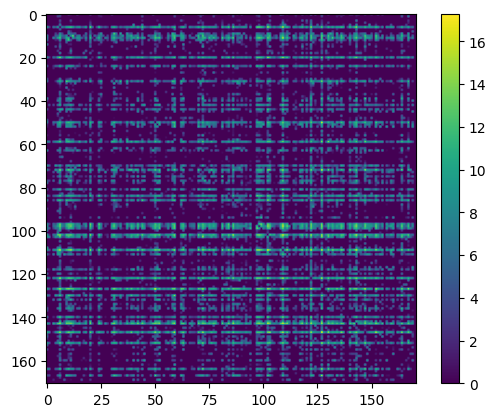

In [231]:
plt.imshow(tf.math.log(adj[0, 0] +1))
#plt.imshow(tf.math.log(tf.abs(adj[0, 0] - logn_samples[0]) +1))
plt.colorbar()

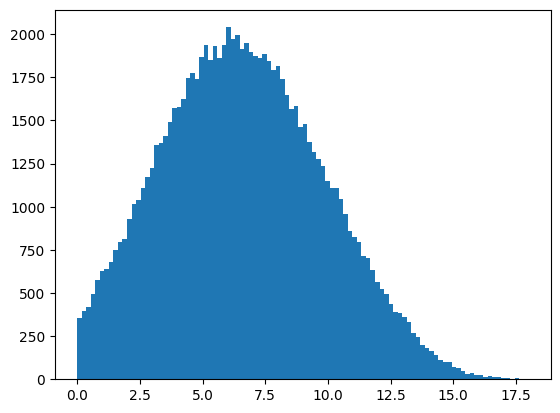

In [225]:
_ = plt.hist(np.log(logn_samples[logn_samples>0].numpy().flatten()), bins=100, range=(0, 18))

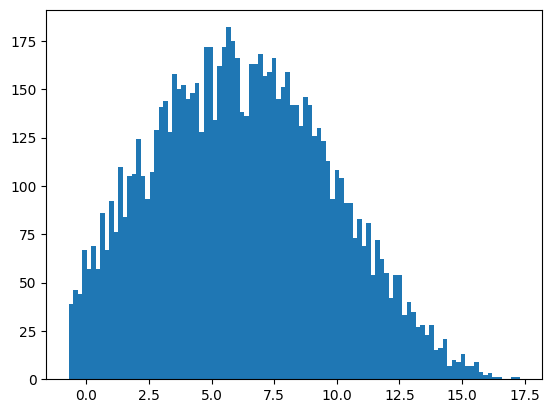

In [223]:
_ = plt.hist(np.log(adj[0,0][adj[0, 0]>0].numpy().flatten() ), bins=100)


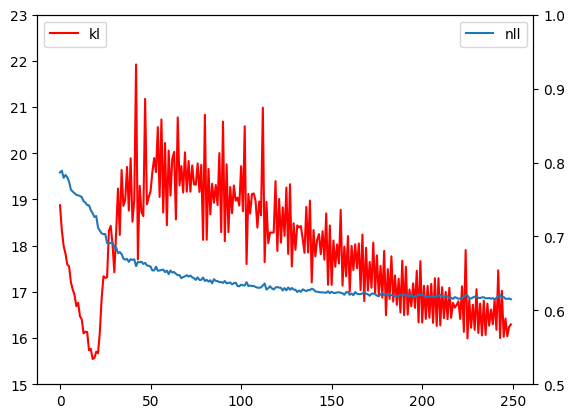

In [198]:
#plt.plot(history2.history["lognormal_loss"])
fig, ax = plt.subplots()
ax.plot(history1b.history["kl"], color="red", label="kl")
ax.set_ylim(15, 23)
sax = ax.twinx()
sax.plot(history1b.history["nll"],label="nll")
sax.set_ylim(0.5, 1)
ax.legend(loc="upper left")
sax.legend(loc="upper right")

In [10]:
*_, adj_out, h = model((x[:, :-1], adj[:,:-1, :, :]))

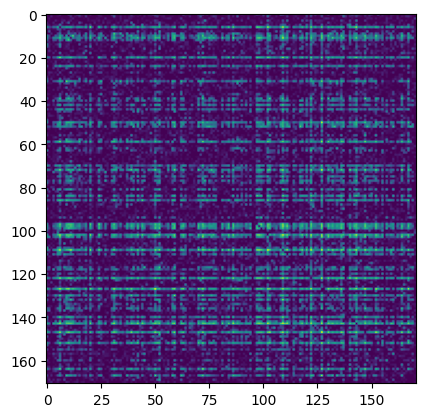

In [199]:
T = 2
samples = model.sample((x[:, :], adj[:,:, :, :]))[0, 0, :]

adj_in = adj[0, :, :,:]
log_samples = np.where(samples>0, np.log(samples+1), 0)
log_inputs = np.where(adj_in>0, np.log(adj_in+1), adj_in)
abs_diff = np.abs(log_samples - log_inputs)
plt.imshow(abs_diff[T])

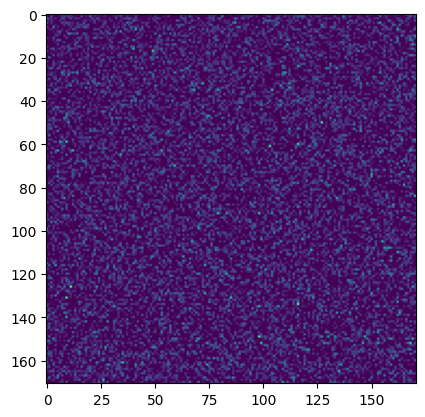

In [200]:
samples = tf.reduce_mean(model.sample((x[:, :], adj[:,:, :, :]), None,1), 0)[0]
log_samples = np.where(samples>0, np.log(samples+1), 0)
plt.imshow(log_samples[-1])

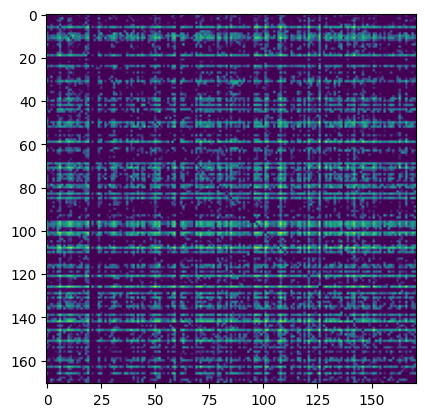

In [275]:
plt.imshow(log_inputs[-1])

(array([1.9721e+04, 1.8555e+04, 1.6763e+04, 1.4398e+04, 1.1854e+04,
        9.4960e+03, 7.2840e+03, 5.5910e+03, 3.9990e+03, 2.8560e+03,
        1.9860e+03, 1.3730e+03, 9.3900e+02, 6.7600e+02, 4.2500e+02,
        3.1700e+02, 2.2200e+02, 1.6300e+02, 1.1500e+02, 7.6000e+01,
        4.1000e+01, 2.9000e+01, 3.7000e+01, 2.0000e+01, 1.4000e+01,
        1.1000e+01, 7.0000e+00, 6.0000e+00, 5.0000e+00, 2.0000e+00,
        4.0000e+00, 2.0000e+00, 1.0000e+00, 4.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.00

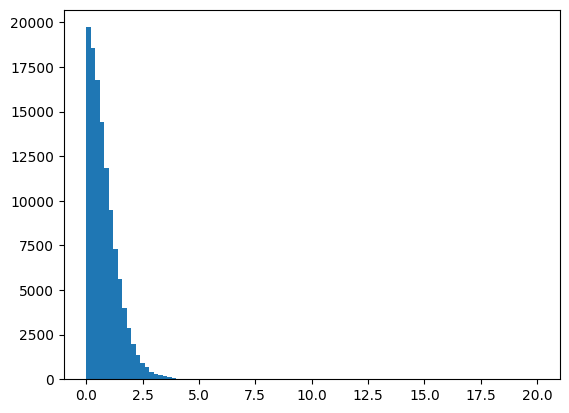

In [204]:
plt.hist(np.log(samples[samples>0].numpy().flatten()), bins=100, range=(0, 20))

(array([1.890e+03, 1.730e+03, 1.811e+03, 2.116e+03, 1.986e+03, 2.240e+03,
        2.352e+03, 2.356e+03, 2.483e+03, 2.509e+03, 2.655e+03, 2.635e+03,
        2.755e+03, 2.916e+03, 3.032e+03, 3.106e+03, 3.086e+03, 3.255e+03,
        3.287e+03, 3.409e+03, 3.480e+03, 3.643e+03, 3.615e+03, 3.631e+03,
        3.682e+03, 3.656e+03, 3.685e+03, 3.757e+03, 3.795e+03, 3.890e+03,
        3.658e+03, 3.897e+03, 3.858e+03, 3.827e+03, 3.753e+03, 3.687e+03,
        3.690e+03, 3.691e+03, 3.692e+03, 3.536e+03, 3.476e+03, 3.511e+03,
        3.342e+03, 3.220e+03, 3.098e+03, 3.016e+03, 2.915e+03, 2.782e+03,
        2.750e+03, 2.632e+03, 2.602e+03, 2.369e+03, 2.188e+03, 2.168e+03,
        2.015e+03, 1.904e+03, 1.950e+03, 1.816e+03, 1.670e+03, 1.527e+03,
        1.357e+03, 1.271e+03, 1.122e+03, 1.038e+03, 1.046e+03, 1.017e+03,
        8.400e+02, 7.090e+02, 6.100e+02, 5.520e+02, 4.750e+02, 4.360e+02,
        3.970e+02, 2.450e+02, 2.260e+02, 2.350e+02, 1.900e+02, 1.850e+02,
        1.520e+02, 1.070e+02, 9.200e+0

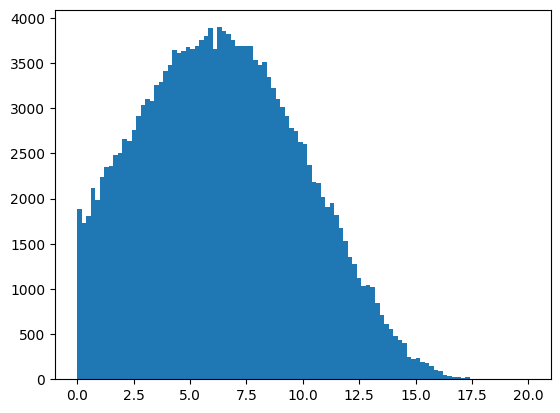

In [183]:
plt.hist(np.log(adj[adj>0].numpy().flatten()), bins=100, range=(0, 20))

In [51]:
np.sum(adj>0)/np.prod(adj.shape)

0.12980693614344133

In [52]:
np.sum(samples.numpy()>0)/np.prod(samples.shape)

0.6366479238754326

In [68]:
_ = rnn((x[:, :-1], adj[:,:-1, :, :, 0]))

In [75]:
tf.reduce_prod([1, 2, 3][:2])

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [37]:
reload(utils)
reload(plotter)

fig = go.Figure(layout=dict(width=1000, height=2500))
plotter.draw_subgraph(G, ['84', '08', '57'], bottom_quantile=.98, top_quantile=1., log_scale=True, normalize=True, plotly=True, fig=fig)

country_code_converter: Country code is not of type string or int


country_code_converter: Country code is not of type string or int


(<Figure size 1500x1500 with 1 Axes>, <GeoAxes: >)

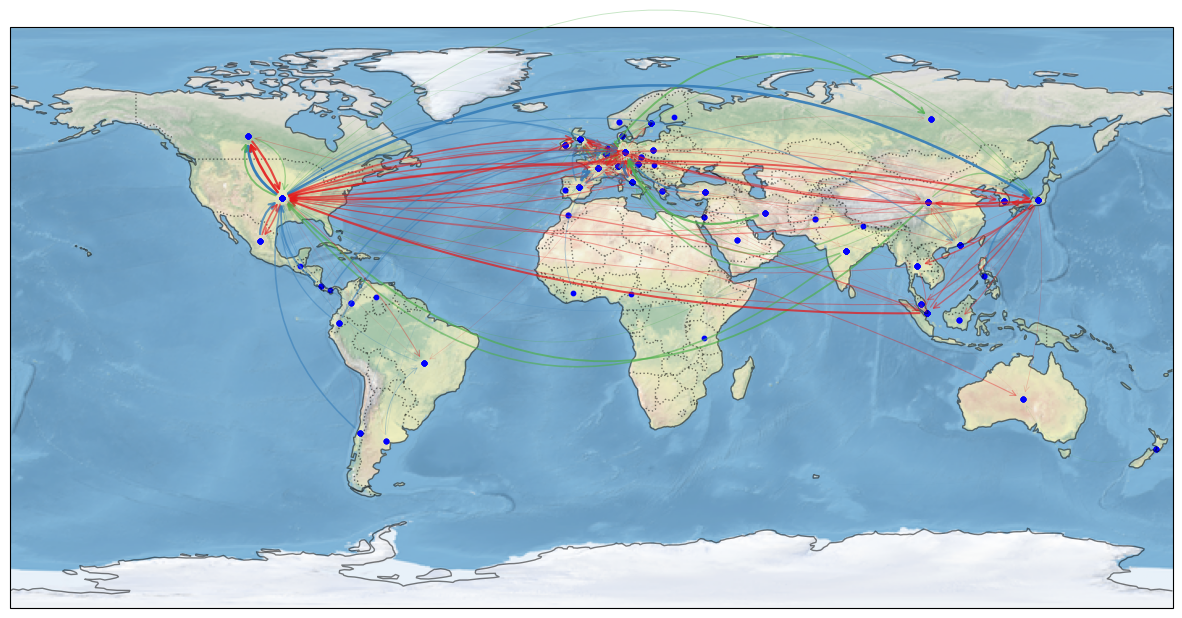

In [38]:
fig = plt.figure(figsize=(15, 15))
plotter.draw_subgraph(G, ['84', '08', '57'], bottom_quantile=.98, top_quantile=1., log_scale=True, normalize=True, plotly=False, fig=fig)
